In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as ti
from matplotlib import cm
from tqdm import tqdm
import cupy as cp
# import cupy

# for pytorch
from torch import zeros, tensor, roll, sin, sqrt, linspace
from torch import sum as tsum
import torch
# from cupy import cupyx
# import cupyx
# import nvtx

# for profiling
# from cupyx.profile import time_range, benchmark

/home/cisco581b/.local/lib/python3.8/site-packages/cupy/_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [82]:
print("Torch version:",torch.__version__)

torch.cuda.get_device_name(0)

Torch version: 2.2.0+cu118


'NVIDIA GeForce GTX 1650 with Max-Q Design'

In [104]:
! nvidia-smi 

Sat Feb 17 21:28:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.07              Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...    On  |   00000000:02:00.0 Off |                  N/A |
| N/A   48C    P0             12W /   35W |      24MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [94]:
# selecting device as cuda if available otherwise will set to cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [69]:
def macroscopic(fin, nx, ny, v):
    rho = tsum(fin,axis=0).to(device)   # sending data to device
    u = zeros((2,nx,ny)).to(device) # sending data to device
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u


In [70]:

def obstacle_fun(cx, cy, r):
    def inner(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return inner


In [71]:
# @time_range()
def equilibrium(rho, u, v, t, nx, ny):
    usqr = (3/2)*(u[0]**2+u[1]**2)
    feq = zeros((9,nx,ny))
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
    return feq.to(device)

In [72]:
# @time_range()
def inivel(uLB, ly, d, nx, ny):
    _,yy = torch.meshgrid(linspace(0, nx - 1, nx), linspace(0, ny - 1, ny))
    yy.to(device)
    vel = zeros((d, nx, ny)).to(device)
    for dir in range(d):
        vel[dir,:,:] = (1-dir) * uLB * (1+1e-4*sin(yy/ly*2*np.pi))
    return vel

In [73]:
Re = 10.0                  # Reynolds number
#------------------------------------------------------------------------------
maxIter = 10000
nx,ny = 420,180             # Domain dimensions
ly = ny-1
uLB = 0.04                  # Inlet velocity NON PHYSICAL??
cx,cy,r = nx//4,ny//2,ny/9  # cylinder coordinates and radius (as integers)
nulb = uLB*r/Re             # Viscosity
omega = 1 / (3*nulb+0.5)    # Relaxation parameter


In [74]:

# lattice velocities
v = tensor([
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ]).int().to(device)

# weights
t = tensor([
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ]).float().to(device)


In [75]:
col_0 = tensor([0,1,2]).long().to(device)
col_1 = tensor([3,4,5]).long().to(device)
col_2 = tensor([6,7,8]).long().to(device)



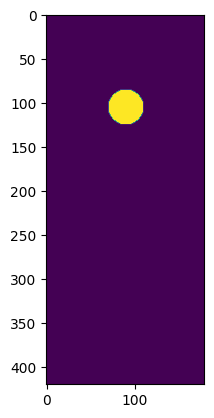

In [76]:
# kwargs['shape'] = [nx, ny]
# instantiate the cylindrical obstacle
obstacle = torch.tensor(np.fromfunction(obstacle_fun(cx,cy,r),(nx, ny)))
if True:
  plt.imshow(obstacle)


 59%|█████████████████████████████████████████████                               | 5934/10000 [03:17<02:15, 30.03it/s]


KeyboardInterrupt: 

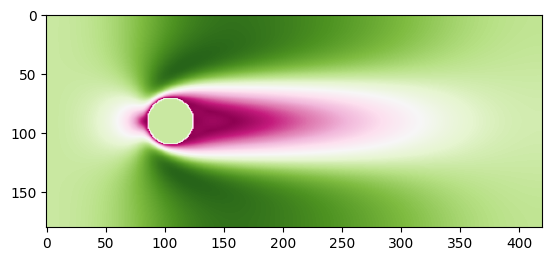

In [79]:

# initial velocity profile
#vel = np.fromfunction(inivel(uLB,ly),(2,nx,ny))
vel = inivel(uLB, ly, 2, nx, ny)

# initialize fin to equilibirum (rho = 1)
fin = equilibrium(1,vel,v,t,nx,ny).to(device)

#==============================================================================
#   Time-Stepping
#==============================================================================
t0 = ti()
for time in tqdm(range(maxIter)):
    # outflow boundary condition (right side) NEUMANN BC! No gradient
    fin[col_2,-1,:] = fin[col_2,-2,:]

    # compute macroscopic variables
    rho,u = macroscopic(fin,nx,ny,v)

    # inlet boundary condition (left wall)
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:])*( tsum(fin[col_1,0,:], axis = 0)+
                                2*tsum(fin[col_2,0,:], axis = 0))

    feq = equilibrium(rho,u,v,t,nx,ny)
    fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]

    # Collide
    fout = fin - omega*(fin-feq)

    # bounceback
    for i in range(9):
        fout[i,obstacle] = fin[8-i,obstacle]

    # stream
    for i in range(9):
        # be careful with this -> numpy.roll cycles through an array by an axis
        # and the last element becomes the first. this implements a periodic
        # boundary in a very compact syntax, but needs to be reworked for other
        # implementations
        fin[i,:,:] = roll(
                          roll(
                                fout[i,:,:], v[i,0].item(), dims = 0
                               ),
                          v[i,1].item(), dims = 1
                          )

    # Output an image every 100 iterations
    if (time%100 == 0):
        plt.clf()
        u_temp = u.cpu()
        x_temp = int(round(5 * nx / ny))
        y_temp = int(round(5))
        plt.imshow(sqrt(u_temp[0]**2+u_temp[1]**2).T, cmap= 'PiYG')
        plt.savefig("./testFolder/vel{0:03d}.png".format(time//100))
tf = ti() - t0

print("time to execute = ",tf)

In [80]:
! nsys profile -t cuda,nvtx python3 nvtx.py

Torch version: 2.2.0+cu118
cuda
/home/cisco581b/.local/lib/python3.8/site-packages/cupy/_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
Traceback (most recent call last):
  File "nvtx.py", line 21, in <module>
    import nvtx

In [ ]:
# ! nsys analyze report5.nsys-rep

